In [48]:
import os
import pandas as pd
from openpyxl import load_workbook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import copy
import matplotlib as mpl
from scipy.optimize import curve_fit

In [26]:
pathName = r'C:\DTU\Data\201901_JanuaryExpt\DataExtracted\IndividualTrials\EyeMovements\Subject_Block_Session_Trial_EyeMovements.xlsx'
corrFileName = r'C:\DTU\Data\201901_JanuaryExpt\DataExtracted\IndividualSessions_TrialAvg\Pupils\Subject_Block_Session_PupilSizeCorrelation2.xlsx'


df = pd.read_excel(open(pathName, 'rb'), sheet_name='Sheet1')
df_woNa = copy.deepcopy(df)

corr = pd.read_excel(open(corrFileName, 'rb'), sheet_name='Sheet1')
corr_short = corr[corr.Correlation>0.75]



In [27]:
Day = [str(day) for day in df.Day]
df['Day'] = Day
DayNr = [day[0] for day in df.Day]

df['DayNr'] = DayNr

TypingTechnique = ['MS' if len(day)>1 else 'DT' for day in df.Day]

df['TypingTechnique'] = TypingTechnique



In [28]:
df1 = df.merge(corr_short, on=['Subject','Day', 'Session'])


df1.to_csv(r'C:\DTU\Data\201901_JanuaryExpt\DataExtracted\IndividualTrials\EyeMovements\Subject_Block_Session_Trial_EyeMovements.csv', sep=',',na_rep='', header=True, index=False)


In [70]:
plt.plot(df1.SaccadeDuration_reading, df1.SaccadeAmplitude_reading, 'o')
plt.xlabel('Duration [s]')
plt.ylabel('Amplitude [deg]')

Text(0, 0.5, 'Amplitude [deg]')

In [31]:
plt.plot(df1.SaccadeAmplitude_reading, df1.SaccadeVelocity_reading, 'o')
plt.ylabel('Velocity [deg/s]')
plt.xlabel('Amplitude [deg]')


Text(0.5, 0, 'Amplitude [deg]')

In [32]:
plt.plot(df1.SaccadeAmplitude_reading, df1.SaccadePeakVelocity_reading, 'o')
plt.ylabel('Peak Velocity [deg/s]')
plt.xlabel('Amplitude [deg]')


Text(0.5, 0, 'Amplitude [deg]')

In [38]:
plt.plot(df1.SaccadeAmplitude_reading[df1.FatigueDifference<0], df1.SaccadePeakVelocity_reading[df1.FatigueDifference<0],\
         'o')
plt.plot(df1.SaccadeAmplitude_reading[df1.FatigueDifference>0], df1.SaccadePeakVelocity_reading[df1.FatigueDifference>0],\
         'o')
plt.ylabel('Peak Velocity [deg/s]')
plt.xlabel('Amplitude [deg]')


Text(0.5, 0, 'Amplitude [deg]')

In [50]:
df1_woNa = df1.dropna(inplace=False, axis=0)

In [68]:
# curve fitting to velocity-amplitude curves [Stasi 2013]

def func(x, b, m):
    return np.exp(b) * (x**m)

plt.figure()
x = np.array(df1_woNa.SaccadeAmplitude_reading[df1_woNa.FatigueDifference>0].tolist())
y = np.array(df1_woNa.SaccadePeakVelocity_reading[df1_woNa.FatigueDifference>0].tolist())

popt, pcov = curve_fit(func, x, y)
plt.plot(x, y, 'ob', label='Fatigue Reduced')
plt.plot(x, func(x, *popt), 'og', label='fit: b=%5.3f, m=%5.3f' % tuple(popt))


x = np.array(df1_woNa.SaccadeAmplitude_reading[df1_woNa.FatigueDifference<0].tolist())
y = np.array(df1_woNa.SaccadePeakVelocity_reading[df1_woNa.FatigueDifference<0].tolist())

popt, pcov = curve_fit(func, x, y)
plt.plot(x, y, 'or', label='Fatigue Increased', alpha = 0.5)
plt.plot(x, func(x, *popt), 'oc', alpha = 0.5, label='fit: b=%5.3f, m=%5.3f' % tuple(popt))
plt.legend()
plt.ylabel('Peak Velocity [deg/s]')
plt.xlabel('Amplitude [deg]')

Text(0.5, 0, 'Amplitude [deg]')

In [45]:
PlotTitle = 'SaccadePeakVelocity_reading'
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plot_variables = ['SaccadePeakVelocity_reading']


#boxplot = df1[df1.SessionDifficulty=='E'].boxplot(column=plot_variables, sym='', positions=None, widths=None, \
#        patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, showmeans=True, \
#        showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, \
#        meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None)

#x_inds = [1, 3.5, 6, 8.5]
x_inds = [1]

list1 = list()
x_list1 = list()

for ind, variable in enumerate(plot_variables):
    
    list1.append(df1[variable][df1.SessionDifficulty=='E'].mean())
    list1.append(df1[variable][df1.SessionDifficulty=='D'].mean())
    x_list1.append(x_inds[ind])
    x_list1.append(x_inds[ind]+0.8)
    p1 = ax1.bar(x_inds[ind], df1[variable][df1.SessionDifficulty=='E'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='E'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='E'].count()), color='orange', label='Easy')
    
    p2 = ax1.bar(x_inds[ind]+0.8, df1[variable][df1.SessionDifficulty=='D'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='D'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='D'].count()), color='blue', label='Difficult')
    
    
ax1.plot(x_list1, list1, '-.', color='k', markersize = 16)
    
ax1.set_title(PlotTitle)
ax1.set_xticks([1,1.8])
ax1.set_xticklabels(['Easy', 'Difficult'])
#ax1.set_ylim([-0.5, 0.6])
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': 32})
#ax1.legend((p1, p2), ('Easy', 'Difficult'))

savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\SaccadePeakVelocity_reading_sessionDifficulty.png' 
fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))

In [46]:
variable = 'SaccadePeakVelocity_reading'


timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
colorList = ['orange', 'blue']

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    
    
    p1 = ax1.bar(1, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), \
                    df1.SessionDifficulty==session1Difficulty)].mean(), yerr = df1[variable][np.logical_and(\
                    np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), df1.SessionDifficulty==session1Difficulty)\
                    ].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT',\
                    df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())),color = colorList[0])
    p2 = ax1.bar(2, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].mean(), \
                 yerr = df1[variable][np.logical_and(np.logical_and(\
                    df1.TypingTechnique=='DT', df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/\
                    (np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].count())), color = colorList[1])
    
    
    ax1.set_ylabel('SaccadePeakVelocity_reading')
    ax1.set_xlabel('Trials')
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(['Session 1', 'Session2'])
    #ax1.set_ylim([-0.13, 0])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1,p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\SaccadePeakVelocity_reading_Session1_' + \
    session1Difficulty + '.png' 
    fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    colorList = ['blue', 'orange']
    
    




In [43]:


variable = 'SaccadePeakVelocity_reading'



timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
session1Color = 'blue'
session2Color = 'orange'

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    for ind, trial in enumerate(np.unique(df1.Trial)):
        
        if trial > 4:
            continue
    
        p1 = ax1.errorbar(trial+1, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())), marker = 'o', ms=30, color = session1Color)
        p2 = ax1.errorbar(trial+6, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].count())), marker = 'o', ms=30, color = session2Color)
    
    ax1.set_ylabel('SaccadePeakVelocity_reading')
    ax1.set_xlabel('Trials')
    #ax1.set_ylim([-2, 0.4])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1, p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\SaccadePeakVelocity_reading_TimeOnTask_' + 'Session1_' + \
    session1Difficulty + '.png' 
    fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    session1Color = 'orange'
    session2Color = 'blue'
    
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': label_fontSize})
#ax1.legend((p1, p2), ('Session1', 'Session2'))






In [ ]:
PlotTitle = 'distanceMean_reading'
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plot_variables = ['distanceMean_reading']


#boxplot = df1[df1.SessionDifficulty=='E'].boxplot(column=plot_variables, sym='', positions=None, widths=None, \
#        patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, showmeans=True, \
#        showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, \
#        meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None)

#x_inds = [1, 3.5, 6, 8.5]
x_inds = [1]

list1 = list()
x_list1 = list()

for ind, variable in enumerate(plot_variables):
    
    list1.append(df1[variable][df1.SessionDifficulty=='E'].mean())
    list1.append(df1[variable][df1.SessionDifficulty=='D'].mean())
    x_list1.append(x_inds[ind])
    x_list1.append(x_inds[ind]+0.8)
    p1 = ax1.bar(x_inds[ind], df1[variable][df1.SessionDifficulty=='E'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='E'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='E'].count()), color='orange', label='Easy')
    
    p2 = ax1.bar(x_inds[ind]+0.8, df1[variable][df1.SessionDifficulty=='D'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='D'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='D'].count()), color='blue', label='Difficult')
    
    
ax1.plot(x_list1, list1, '-.', color='k', markersize = 16)
    
ax1.set_title(PlotTitle)
ax1.set_xticks([1,1.8])
ax1.set_xticklabels(['Easy', 'Difficult'])
#ax1.set_ylim([-0.5, 0.6])
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': 32})
#ax1.legend((p1, p2), ('Easy', 'Difficult'))


In [21]:
PlotTitle = 'distanceMean_reading'
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plot_variables = ['distanceMean_reading']


#boxplot = df1[df1.SessionDifficulty=='E'].boxplot(column=plot_variables, sym='', positions=None, widths=None, \
#        patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, showmeans=True, \
#        showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, \
#        meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None)

#x_inds = [1, 3.5, 6, 8.5]
x_inds = [1]

list1 = list()
x_list1 = list()

for ind, variable in enumerate(plot_variables):
    
    list1.append(df1[variable][df1.SessionDifficulty=='E'].mean())
    list1.append(df1[variable][df1.SessionDifficulty=='D'].mean())
    x_list1.append(x_inds[ind])
    x_list1.append(x_inds[ind]+0.8)
    p1 = ax1.bar(x_inds[ind], df1[variable][df1.SessionDifficulty=='E'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='E'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='E'].count()), color='orange', label='Easy')
    
    p2 = ax1.bar(x_inds[ind]+0.8, df1[variable][df1.SessionDifficulty=='D'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='D'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='D'].count()), color='blue', label='Difficult')
    
    
ax1.plot(x_list1, list1, '-.', color='k', markersize = 16)
    
ax1.set_title(PlotTitle)
ax1.set_xticks([1,1.8])
ax1.set_xticklabels(['Easy', 'Difficult'])
#ax1.set_ylim([-0.5, 0.6])
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': 32})
#ax1.legend((p1, p2), ('Easy', 'Difficult'))


In [11]:
variable = 'distanceMean_reading'


timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
colorList = ['orange', 'blue']

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    
    
    p1 = ax1.bar(1, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), \
                    df1.SessionDifficulty==session1Difficulty)].mean(), yerr = df1[variable][np.logical_and(\
                    np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), df1.SessionDifficulty==session1Difficulty)\
                    ].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT',\
                    df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())),color = colorList[0])
    p2 = ax1.bar(2, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].mean(), \
                 yerr = df1[variable][np.logical_and(np.logical_and(\
                    df1.TypingTechnique=='DT', df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/\
                    (np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].count())), color = colorList[1])
    
    
    ax1.set_ylabel('distanceMean_reading')
    ax1.set_xlabel('Trials')
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(['Session 1', 'Session2'])
    #ax1.set_ylim([-0.13, 0])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1,p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    #savefilename = r'C:\DTU\Results\201901_Expt\2020FatigueResults\PupilAbsolute_baseline_TimeOnTask_' + 'Session1_' + \
    #session1Difficulty + '.png' 
    ##fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    colorList = ['blue', 'orange']
    
    




In [10]:


variable = 'distanceMean_reading'



timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
session1Color = 'blue'
session2Color = 'orange'

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    for ind, trial in enumerate(np.unique(df1.Trial)):
        
        if trial > 4:
            continue
    
        p1 = ax1.errorbar(trial+1, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())), marker = 'o', ms=30, color = session1Color)
        p2 = ax1.errorbar(trial+6, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].count())), marker = 'o', ms=30, color = session2Color)
    
    ax1.set_ylabel('distanceMean_reading')
    ax1.set_xlabel('Trials')
    #ax1.set_ylim([0.00, 0.27])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1, p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\distanceMean_reading_TimeOnTask_' + 'Session1_' + \
    session1Difficulty + '.png' 
    fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    session1Color = 'orange'
    session2Color = 'blue'
    
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': label_fontSize})
#ax1.legend((p1, p2), ('Session1', 'Session2'))






In [12]:
PlotTitle = 'distanceMean_writing'
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

plot_variables = ['distanceMean_writing']


#boxplot = df1[df1.SessionDifficulty=='E'].boxplot(column=plot_variables, sym='', positions=None, widths=None, \
#        patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, showmeans=True, \
#        showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, \
#        meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None)

#x_inds = [1, 3.5, 6, 8.5]
x_inds = [1]

list1 = list()
x_list1 = list()

for ind, variable in enumerate(plot_variables):
    
    list1.append(df1[variable][df1.SessionDifficulty=='E'].mean())
    list1.append(df1[variable][df1.SessionDifficulty=='D'].mean())
    x_list1.append(x_inds[ind])
    x_list1.append(x_inds[ind]+0.8)
    p1 = ax1.bar(x_inds[ind], df1[variable][df1.SessionDifficulty=='E'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='E'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='E'].count()), color='orange', label='Easy')
    
    p2 = ax1.bar(x_inds[ind]+0.8, df1[variable][df1.SessionDifficulty=='D'].mean(), yerr = \
                 df1[variable][df1.SessionDifficulty=='D'].std()/np.sqrt(df1[variable][df1.SessionDifficulty=='D'].count()), color='blue', label='Difficult')
    
    
ax1.plot(x_list1, list1, '-.', color='k', markersize = 16)
    
ax1.set_title(PlotTitle)
ax1.set_xticks([1,1.8])
ax1.set_xticklabels(['Easy', 'Difficult'])
#ax1.set_ylim([-0.5, 0.6])
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': 32})
#ax1.legend((p1, p2), ('Easy', 'Difficult'))


In [14]:
variable = 'distanceMean_writing'


timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
colorList = ['orange', 'blue']

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    
    
    p1 = ax1.bar(1, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), \
                    df1.SessionDifficulty==session1Difficulty)].mean(), yerr = df1[variable][np.logical_and(\
                    np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), df1.SessionDifficulty==session1Difficulty)\
                    ].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT',\
                    df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())),color = colorList[0])
    p2 = ax1.bar(2, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].mean(), \
                 yerr = df1[variable][np.logical_and(np.logical_and(\
                    df1.TypingTechnique=='DT', df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/\
                    (np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].count())), color = colorList[1])
    
    
    ax1.set_ylabel('distanceMean_writing')
    ax1.set_xlabel('Trials')
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(['Session 1', 'Session2'])
    #ax1.set_ylim([-0.13, 0])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1,p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    #savefilename = r'C:\DTU\Results\201901_Expt\2020FatigueResults\PupilAbsolute_baseline_TimeOnTask_' + 'Session1_' + \
    #session1Difficulty + '.png' 
    ##fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    colorList = ['blue', 'orange']
    
    




In [15]:


variable = 'distanceMean_writing'



timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
session1Color = 'blue'
session2Color = 'orange'

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    for ind, trial in enumerate(np.unique(df1.Trial)):
        
        if trial > 4:
            continue
    
        p1 = ax1.errorbar(trial+1, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())), marker = 'o', ms=30, color = session1Color)
        p2 = ax1.errorbar(trial+6, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].count())), marker = 'o', ms=30, color = session2Color)
    
    ax1.set_ylabel('distanceMean_writing')
    ax1.set_xlabel('Trials')
    #ax1.set_ylim([0.00, 0.27])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1, p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\distanceMean_writing_TimeOnTask_' + 'Session1_' + \
    session1Difficulty + '.png' 
    fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    session1Color = 'orange'
    session2Color = 'blue'
    
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': label_fontSize})
#ax1.legend((p1, p2), ('Session1', 'Session2'))






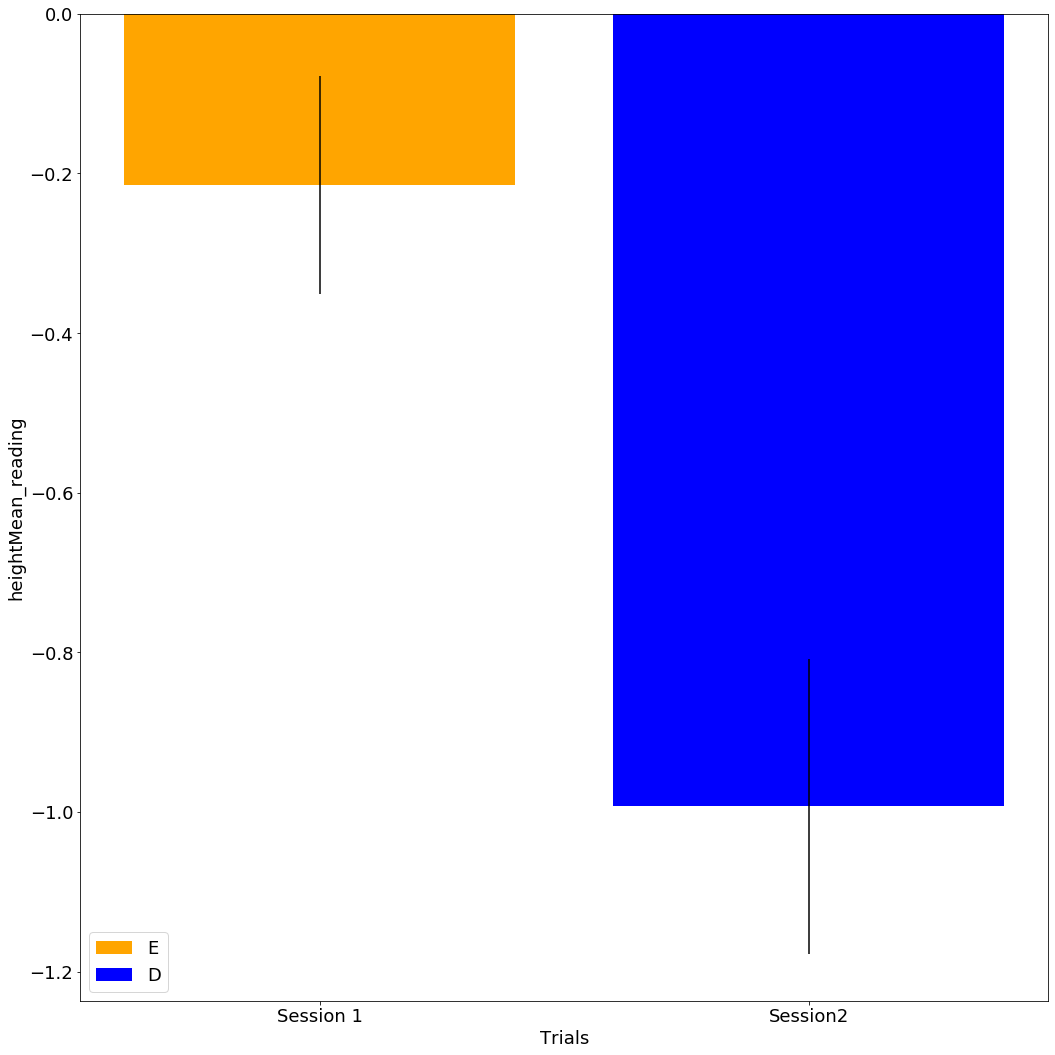

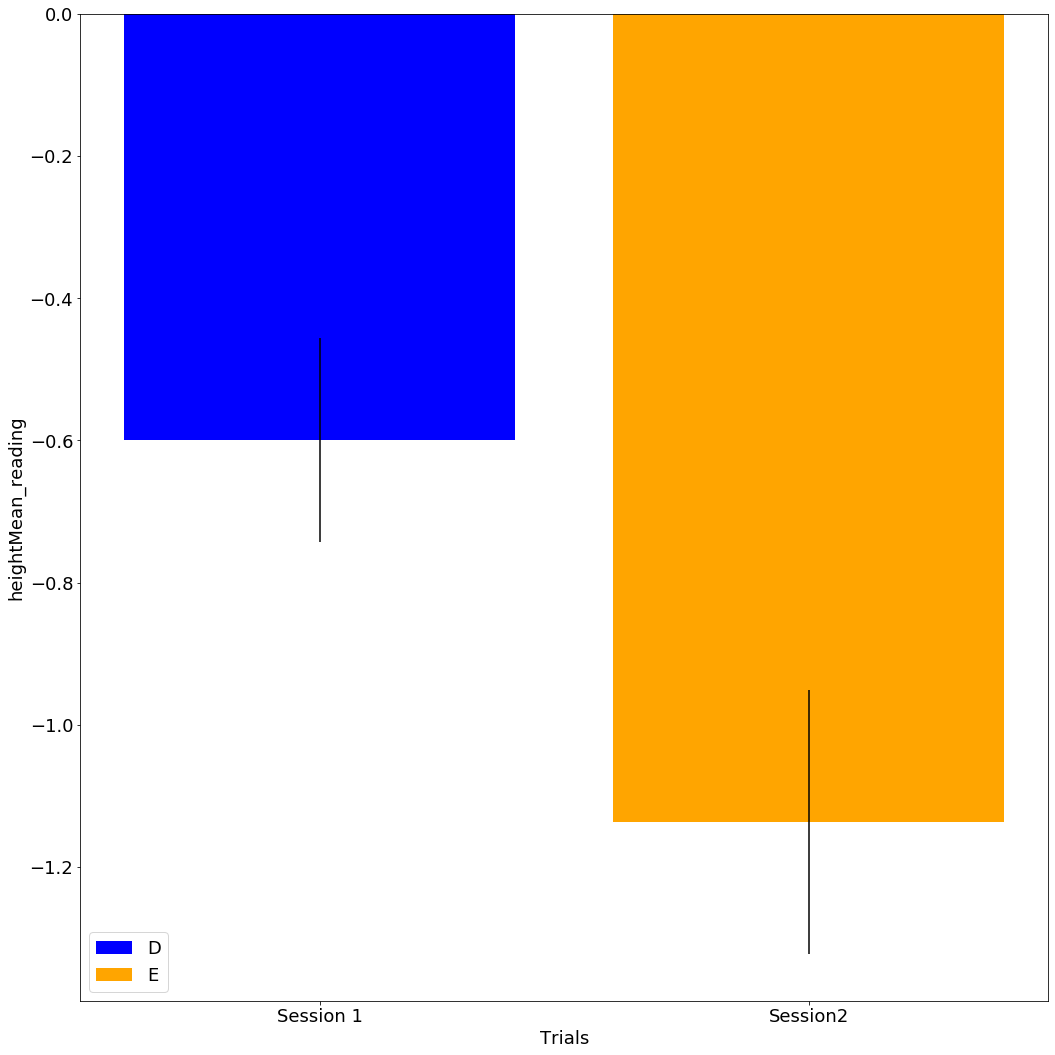

In [18]:


variable = 'heightMean_reading'


timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
colorList = ['orange', 'blue']

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    
    
    p1 = ax1.bar(1, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), \
                    df1.SessionDifficulty==session1Difficulty)].mean(), yerr = df1[variable][np.logical_and(\
                    np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), df1.SessionDifficulty==session1Difficulty)\
                    ].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT',\
                    df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())),color = colorList[0])
    p2 = ax1.bar(2, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].mean(), \
                 yerr = df1[variable][np.logical_and(np.logical_and(\
                    df1.TypingTechnique=='DT', df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/\
                    (np.sqrt(df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2), \
                    df1.SessionDifficulty==session2Difficulty)].count())), color = colorList[1])
    
    
    ax1.set_ylabel('heightMean_reading')
    ax1.set_xlabel('Trials')
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(['Session 1', 'Session2'])
    #ax1.set_ylim([-0.13, 0])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1,p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\heightMean_reading_Session1_' + \
    session1Difficulty + '.png' 
    ##fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    colorList = ['blue', 'orange']
    
    




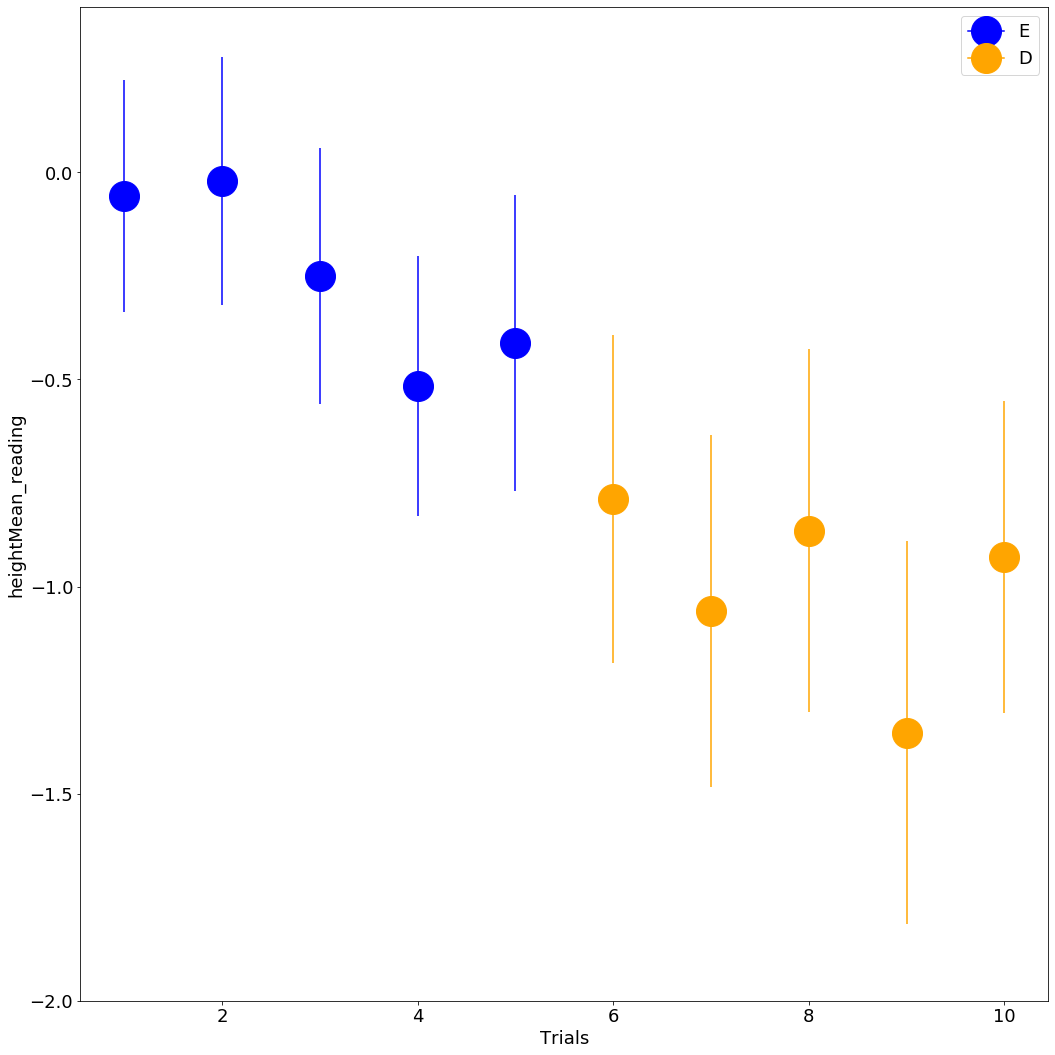

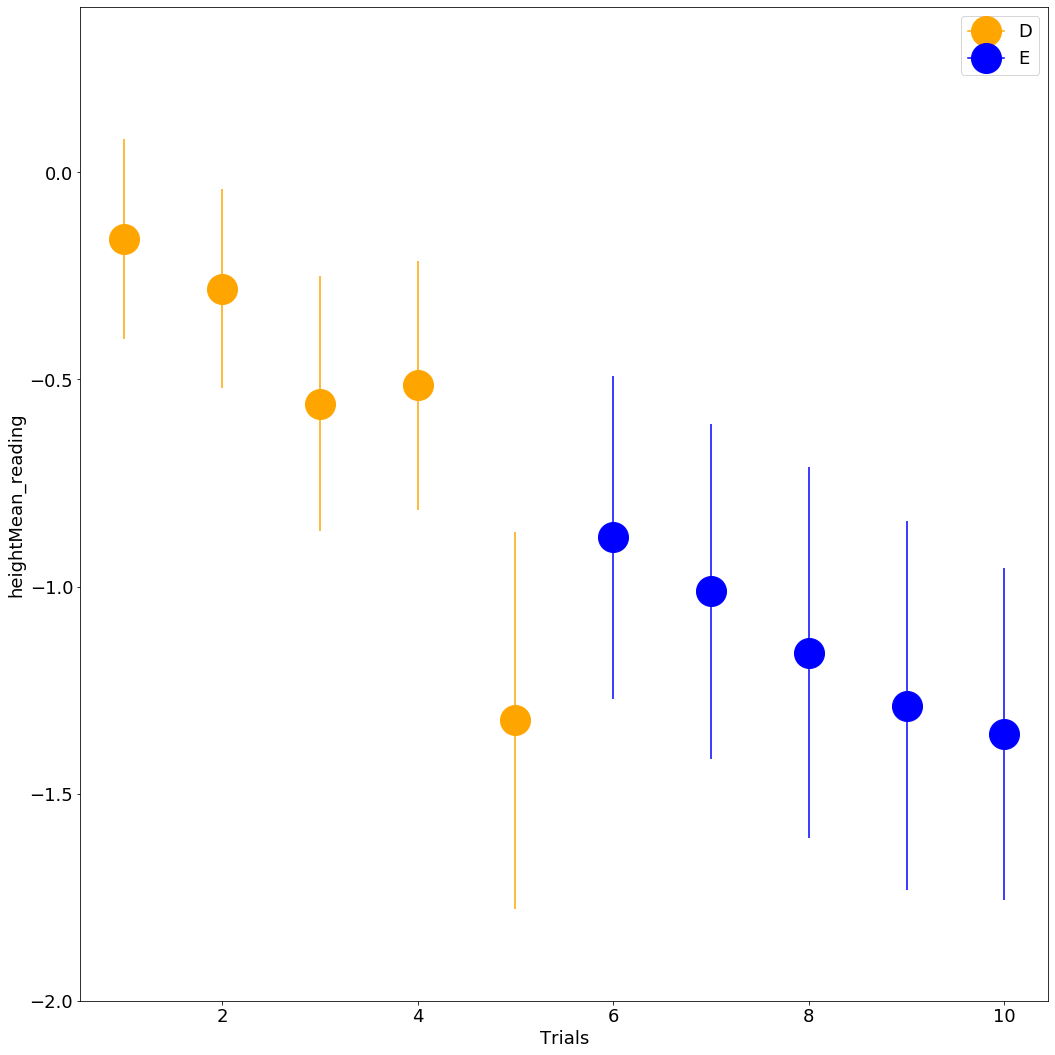

In [21]:


variable = 'heightMean_reading'



timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


session1Difficulty = 'E'
session2Difficulty = 'D'
session1Color = 'blue'
session2Color = 'orange'

for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    for ind, trial in enumerate(np.unique(df1.Trial)):
        
        if trial > 4:
            continue
    
        p1 = ax1.errorbar(trial+1, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty)].count())), marker = 'o', ms=30, color = session1Color)
        p2 = ax1.errorbar(trial+6, df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty)].count())), marker = 'o', ms=30, color = session2Color)
    
    ax1.set_ylabel('heightMean_reading')
    ax1.set_xlabel('Trials')
    ax1.set_ylim([-2, 0.4])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1, p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\heightMean_reading_TimeOnTask_' + 'Session1_' + \
    session1Difficulty + '.png' 
    fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
    session1Difficulty = 'D'
    session2Difficulty = 'E'
    session1Color = 'orange'
    session2Color = 'blue'
    
#ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
plt.rcParams.update({'font.size': label_fontSize})
#ax1.legend((p1, p2), ('Session1', 'Session2'))






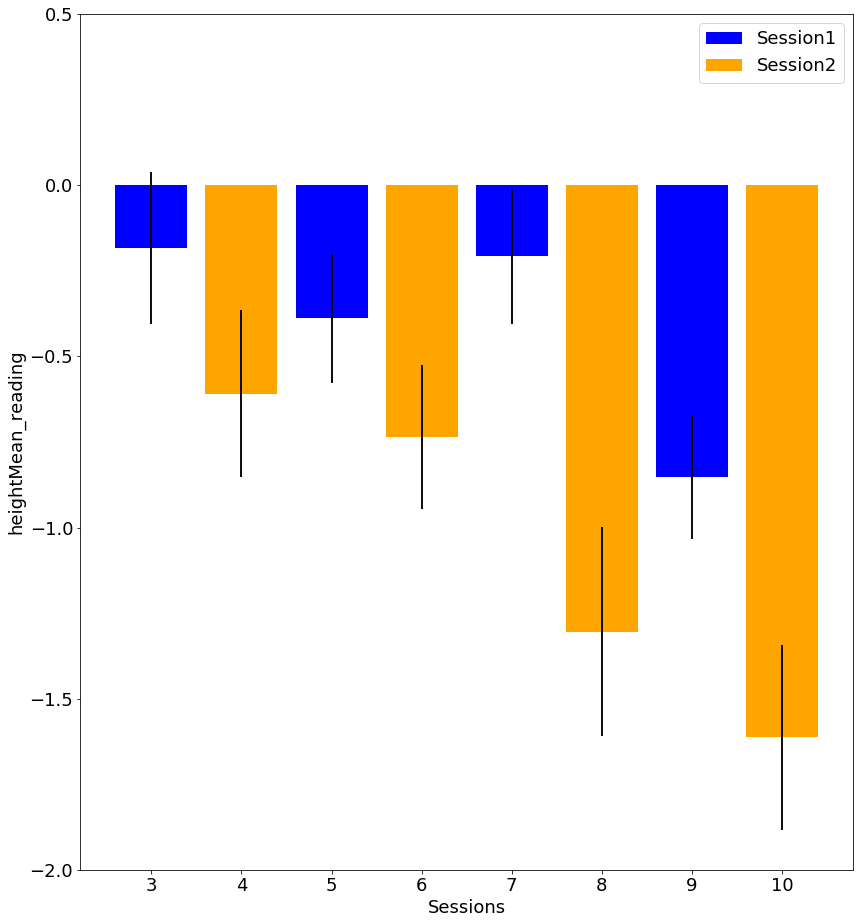

In [14]:


variable = 'heightMean_reading'



timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12

fig = plt.figure(figsize=[15,15])
ax1 = fig.add_subplot(1,1,1)

for i, day in enumerate(np.unique(df1.DayDT)):
    
    if day == 0:
        continue

    
    #for i in range(0,2):
    
    
    
    for ind, Session in enumerate(np.unique(df1.Session)):
        
        p1 = ax1.bar(2*i+1, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==1), \
                    df1.DayDT==day)].mean(), yerr=df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', \
                    df1.Session==1), df1.DayDT==day)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(\
                    df1.TypingTechnique=='DT', df1.Session==1), df1.DayDT==day)].count())), color = 'blue')
        p2 = ax1.bar(2*i+2, df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Session==2),\
                    df1.DayDT==day)].mean(), yerr=df1[variable][np.logical_and(np.logical_and(df1.TypingTechnique=='DT', \
                    df1.Session==2), df1.DayDT==day)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(\
                    df1.TypingTechnique=='DT', df1.Session==2), df1.DayDT==day)].count())), color = 'orange')
            
            
    
    ax1.set_ylabel('heightMean_reading')
    ax1.set_xlabel('Sessions')
    ax1.set_ylim([-2, 0.5])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1, p2), ('Session1', 'Session2'))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\heightMean_reading_Days_Session' + '.png' 
    fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
        
    
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    #ax1.legend((p1, p2), ('Session1', 'Session2'))






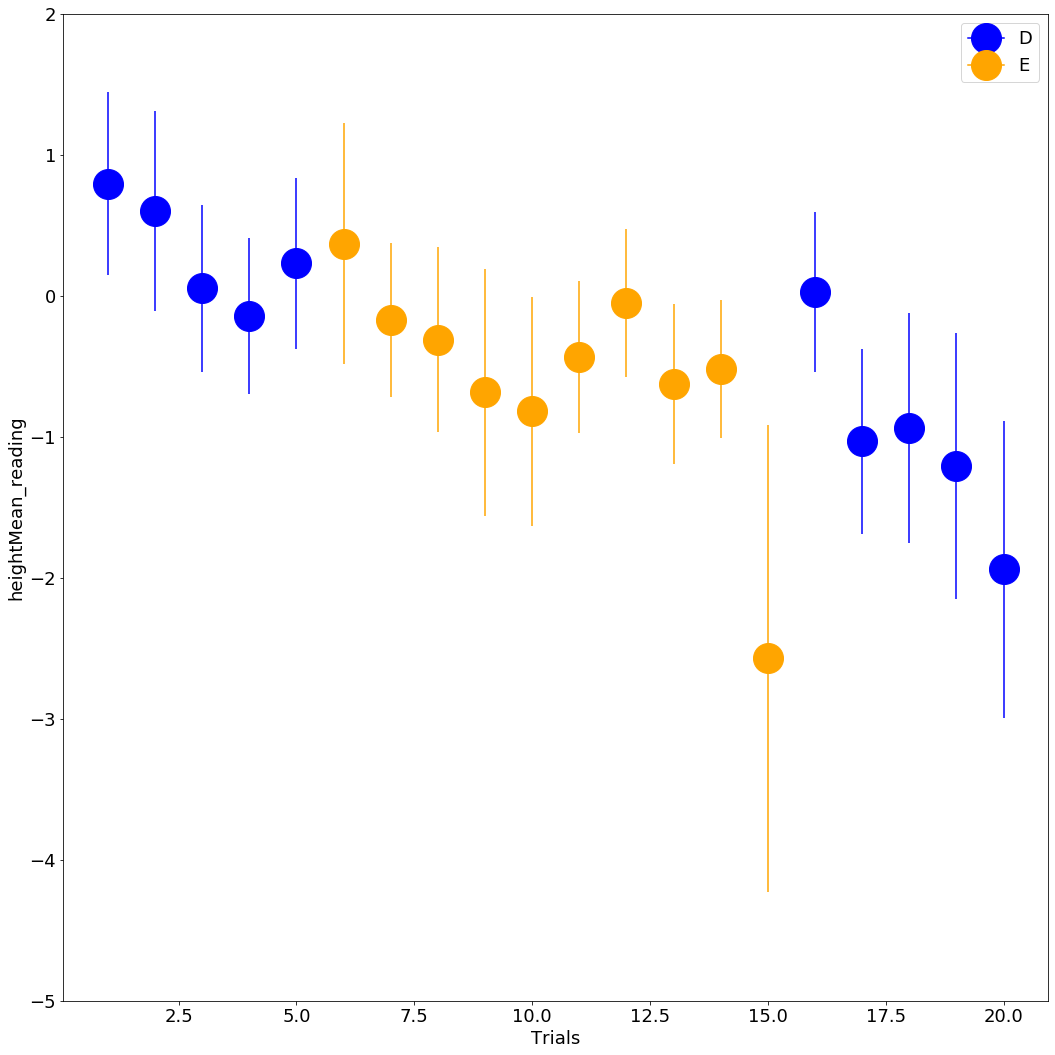

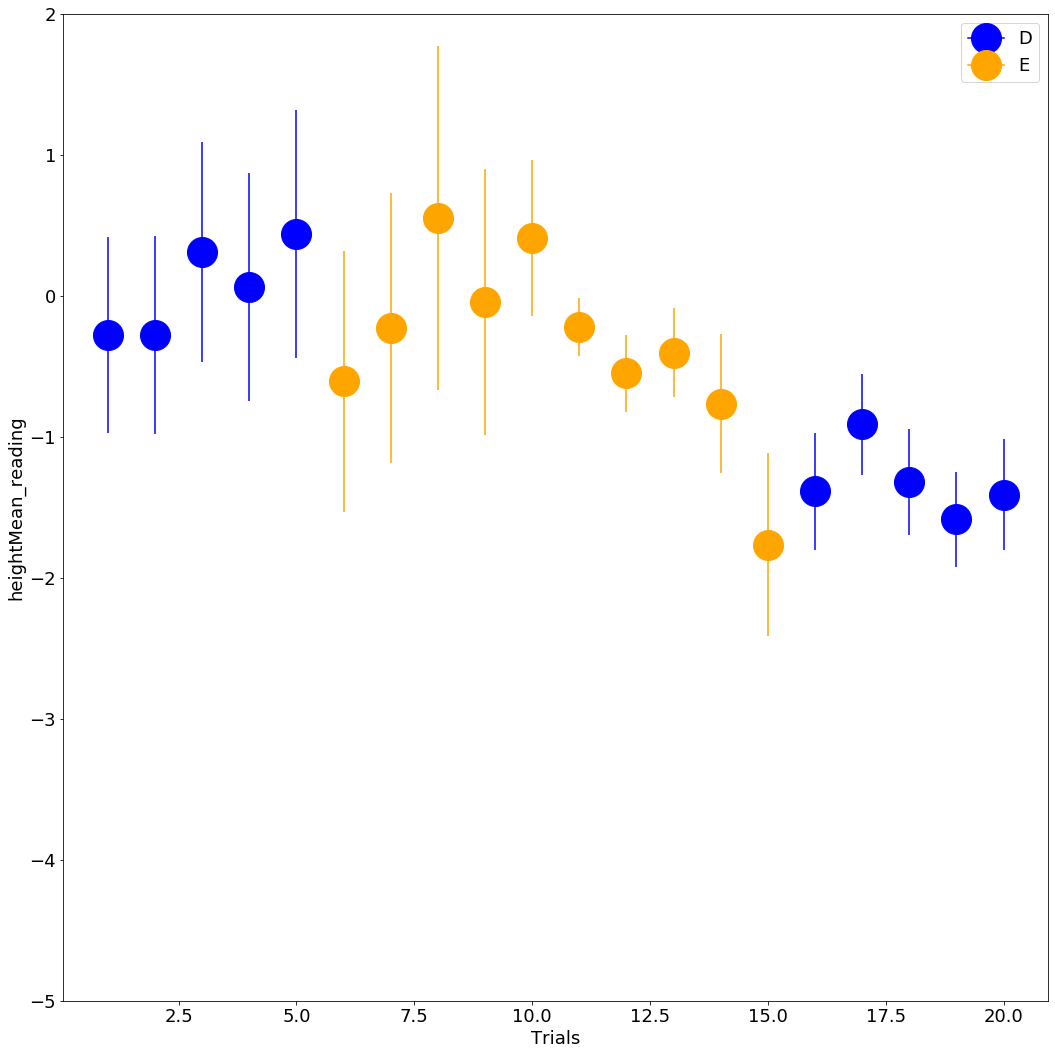

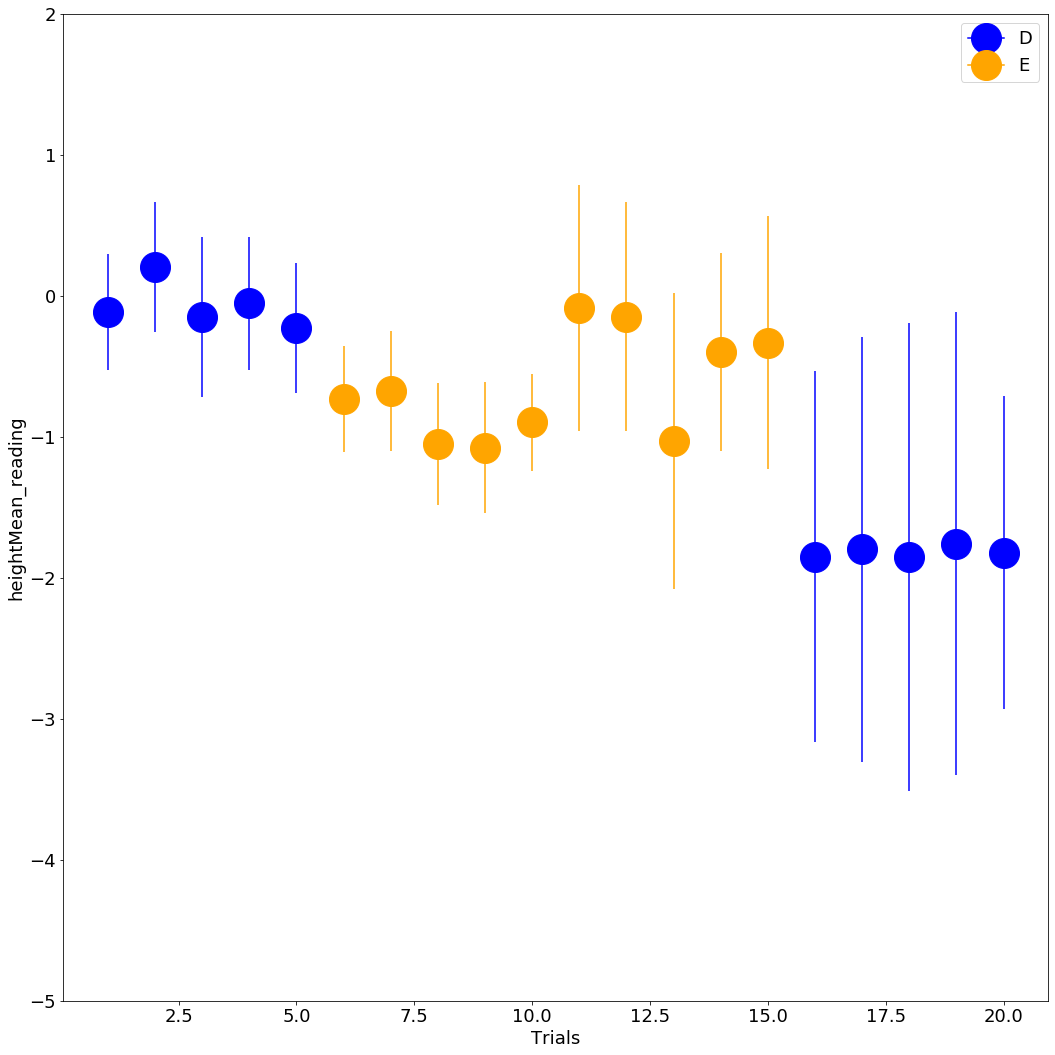

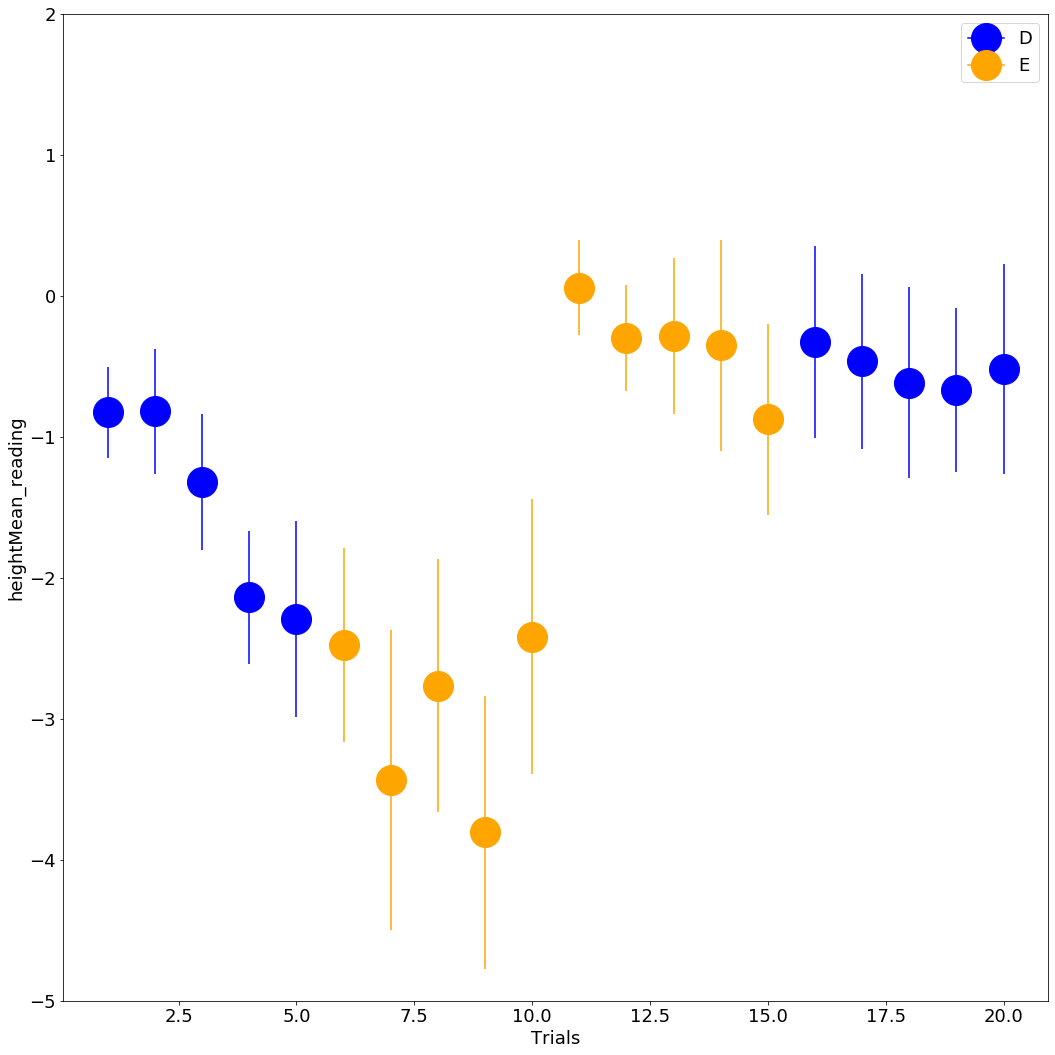

In [8]:


variable = 'heightMean_reading'



timeOnTask = [0, 1, 2, 3, 4]
DayDT = [0,1,2,3]

label_fontSize = 18
others_fontSize = 12


for i, day in enumerate(np.unique(df1.DayDT)):
    
    if day == 0:
        continue

    
    #for i in range(0,2):
    
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(1,1,1)
    
    for ind, trial in enumerate(np.unique(df1.Trial)):
        
        if trial > 4:
            continue
            
        session1Difficulty = 'E'
        session2Difficulty = 'D'
        session1Color = 'blue'
        session2Color = 'orange'

    
        p1 = ax1.errorbar(trial+1, df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty), df1.DayDT==day)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty), df1.DayDT==day)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty), df1.DayDT==day)].count())), marker = 'o', ms=30, color = session1Color)
        p2 = ax1.errorbar(trial+6, df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty), df1.DayDT==day)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty), df1.DayDT==day)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty), df1.DayDT==day)].count())), marker = 'o', ms=30, color = session2Color)
            
            
        session1Difficulty = 'D'
        session2Difficulty = 'E'
        session1Color = 'orange'
        session2Color = 'blue'
        
        p3 = ax1.errorbar(trial+11, df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty), df1.DayDT==day)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty), df1.DayDT==day)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==1), df1.SessionDifficulty==session1Difficulty), df1.DayDT==day)].count())), marker = 'o', ms=30, color = session1Color)
        p4 = ax1.errorbar(trial+16, df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty), df1.DayDT==day)].mean(), df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty), df1.DayDT==day)].std()/(np.sqrt(df1[variable][np.logical_and(np.logical_and(np.logical_and(np.logical_and(df1.TypingTechnique=='DT', df1.Trial==\
                    trial), df1.Session==2), df1.SessionDifficulty==session2Difficulty), df1.DayDT==day)].count())), marker = 'o', ms=30, color = session2Color)
    
    
    ax1.set_ylabel('heightMean_reading')
    ax1.set_xlabel('Trials')
    ax1.set_ylim([-5, 2])
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    ax1.legend((p1, p2), (session1Difficulty, session2Difficulty))
    
    plt.tight_layout()
    savefilename = r'C:\DTU\Results\201901_Expt\Fatigue\heightMean_reading_TimeOnTask_' + 'Session1_' + \
    session1Difficulty + '.png' 
        #fig.savefig(savefilename, dpi = 300, bbox_to_anchor = (0.95, 0.1))
        
    
    #ax1.set_xticklabels(['section1', 'section2', 'section3', 'section4'])
    plt.rcParams.update({'font.size': label_fontSize})
    #ax1.legend((p1, p2), ('Session1', 'Session2'))




